## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'coco-indoor' 
TRANSFORM = 'wavelet-horizontal'
CHANNEL = 'red'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
red_horizontal_wavelet_indoor_coco.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/coco/indoor/wavelet/horizontal/red'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 1604,
 3: 6416,
 4: 25664,
 5: 102656,
 6: 410624,
 7: 1642496,
 8: 6569984,
 9: 26279936}

Running 12760 CDFs


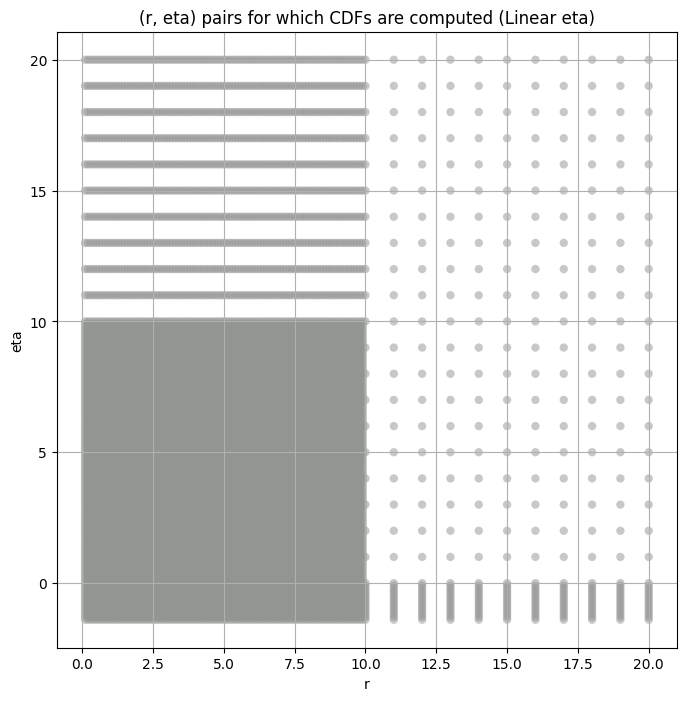

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df['total_samples'] = master_df['total_samples'].astype(int)
    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      6559.191000  6020.007000  7105.842300  -0.362817   -0.544473   
3      1468.433300  1389.056300  1548.781900   0.855831    0.638626   
4       320.184020   302.725500   338.256230   2.609088    2.066685   
5        60.571945    56.585835    64.759430   4.962413    3.983900   
6        10.983582    10.096532    11.949500   8.753280    6.660281   
7         1.917452     1.728934     2.131029  14.216980   10.215151   
8         0.355734     0.312913     0.409800  24.594010   14.979433   
9         0.076622     0.065640     0.092390  41.164585   19.789228   

       kurt_upper  total_samples  
layer                             
2       -0.161276           1604  
3        1.082630           6416  
4        3.449366          25664  
5        6.820006         102656  
6       15.588045         410624  
7       27.708519        1642496  
8       73.025085        6569984  
9      141.374480       26279936

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                               
2      6559.191000    6559.190918     5602.906250     4967.529297   
3      1468.433300    1468.433350     1349.739990     1269.367798   
4       320.184020     320.184021      306.769043      297.934204   
5        60.571945      60.571945       59.278419       58.387177   
6        10.983582      10.983582       10.658253       10.447885   
7         1.917452       1.917452        1.837979        1.788765   
8         0.355734       0.355734        0.335042        0.323135   
9         0.076622       0.076622        0.070505        0.067370   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2         4465.481445      4026.054932      3260.972656      2617.806152   
3         1201.331177      1141.629883      1042.199463       958.100220   
4          290.260956       283.255737       270.564331       259.551941   
5           57.625244        56.928669        55.681404        54.573696   
6           10.266742        10.103000         9.811815         9.554240   
7            1.746969         1.709788         1.644743         1.588374   
8            0.313219         0.304513         0.289510         0.276725   
9            0.064823         0.062624         0.058917         0.055827   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2          2088.481445      1660.942017      1292.841553       533.681641  
3           885.572998       821.223206       762.858643       619.621582  
4           249.861435       241.081039       233.010941       212.212982  
5            53.571869        52.642757        51.772095        49.421989  
6             9.320889         9.106451         8.906806         8.375863  
7             1.538078         1.492552         1.450821         1.341974  
8             0.265490         0.255483         0.246434         0.223578  
9             0.053161         0.050816         0.048722         0.043522

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.09304686353165215 6559.191


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.10008400978118537 5602.9062


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.1103002755471405 4967.5293


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.12305369624564444 4465.4814


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.13554398484013153 4026.055


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.16097041576910665 3260.9727


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.18694507705628371 2617.8062


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.21288247145036754 2088.4814


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.2379391488856777 1660.942


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.26550420077296444 1292.8416


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.348809284135988 533.68164
Number of samples: 1604, Without approximation : 1604


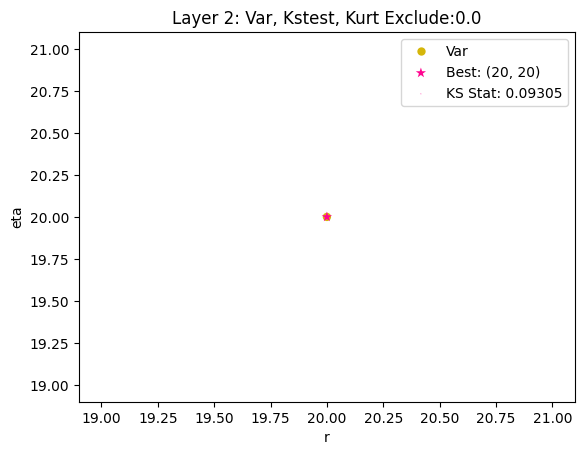

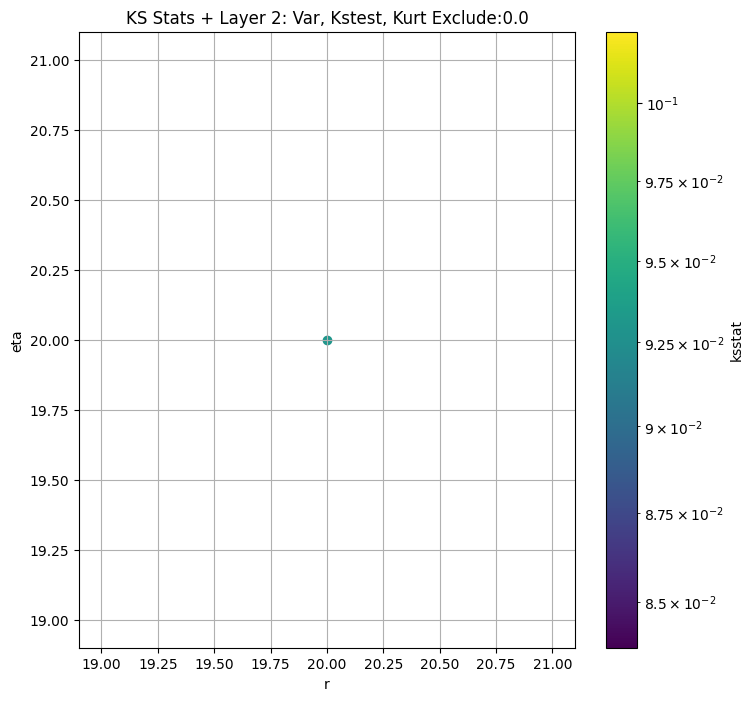

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.053915834200030655 1468.4333


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.053913084172644454 1349.74


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.05391198550428372 1269.3678


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.053911583107604466 1201.3312


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.053937672019221616 1141.6299


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.053955916377524005 1042.1995


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.053983618045182535 958.1002


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.060033419462007465 885.573


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.06764588688888207 821.2232


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.07534422039732913 762.85864


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.09729029706043801 619.6216
Number of samples: 6416, Without approximation : 6416


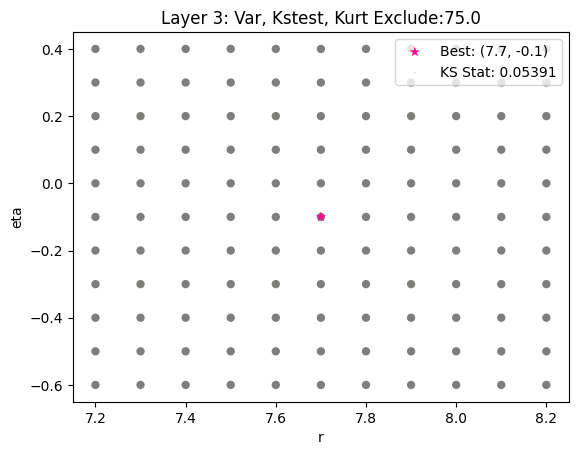

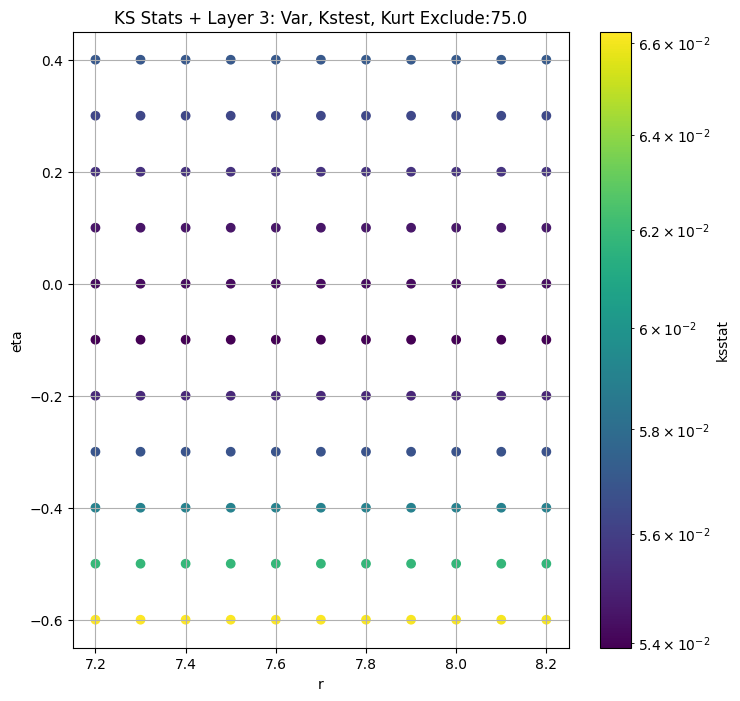

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.04209317995073797 320.18402


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.04208156774107352 306.76904


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.04208650866083358 297.9342


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.042085738146903584 290.26096


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.042085915507723115 283.25574


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.04208606731602865 270.56433


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.04229935206428925 259.55194


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.04228959554271261 249.86143


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.042295247733610986 241.08104


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.04229945105547228 233.01094


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.04230555247450274 212.21298
Number of samples: 25664, Without approximation : 25664


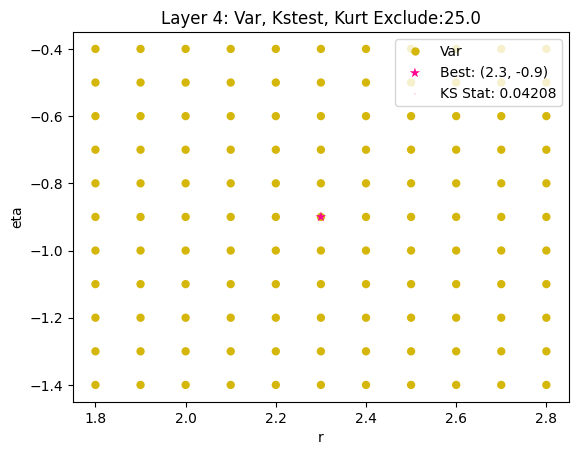

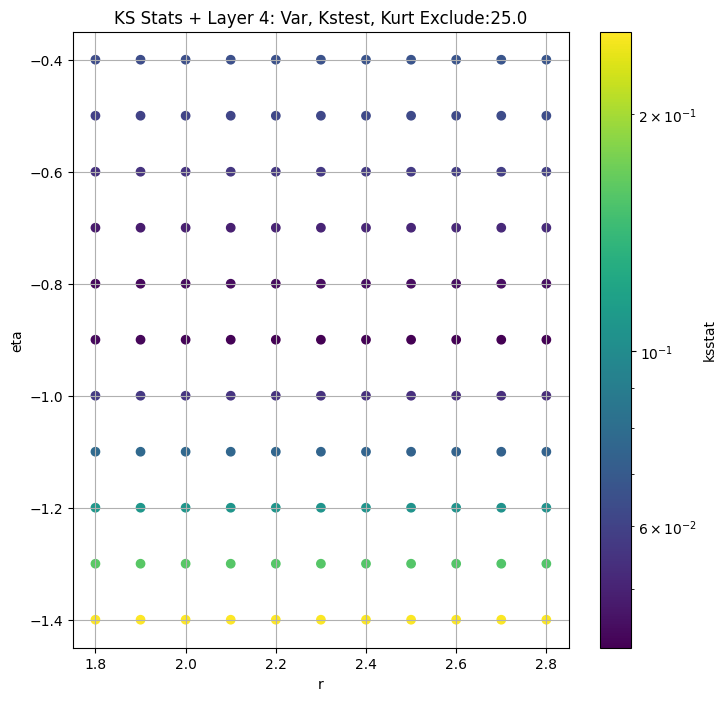

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.03147208415843339 60.571945


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.031696673259338226 59.27842


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.03153482575218791 58.387177


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.031347536857000646 57.625244


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.031473392111703746 56.92867


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.031352928372059 55.681404


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.031385587222775735 54.573696


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.031431784443272826 53.57187


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.03141624916724478 52.642757


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.03143375569807505 51.772095


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.03131682954479709 49.42199
Number of samples: 100000, Without approximation : 102656


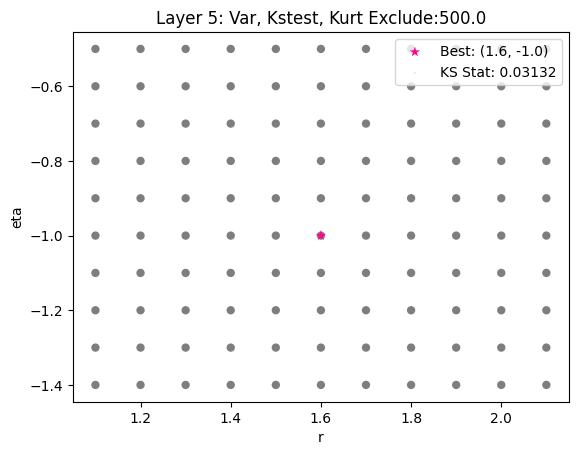

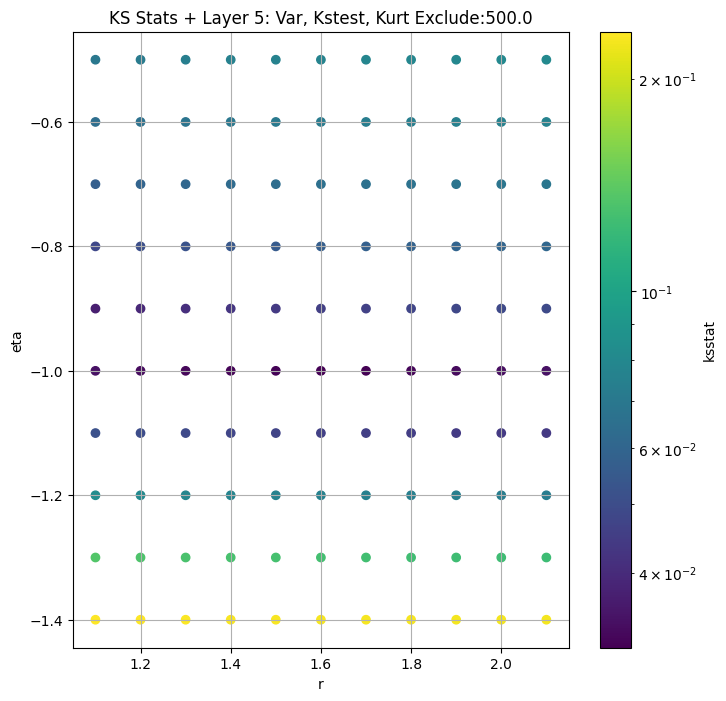

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.02992198211820979 10.983582


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.029784439531004847 10.658253


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.029692333317165642 10.447885


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.029540485098848324 10.266742


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.029535568590670358 10.103


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.029397247460014375 9.811815


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.029274619909037847 9.55424


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.029467607696479492 9.3208885


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.029781659817719186 9.106451


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.029577480445021398 8.906806


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.029281439952987875 8.375863
Number of samples: 100000, Without approximation : 410624


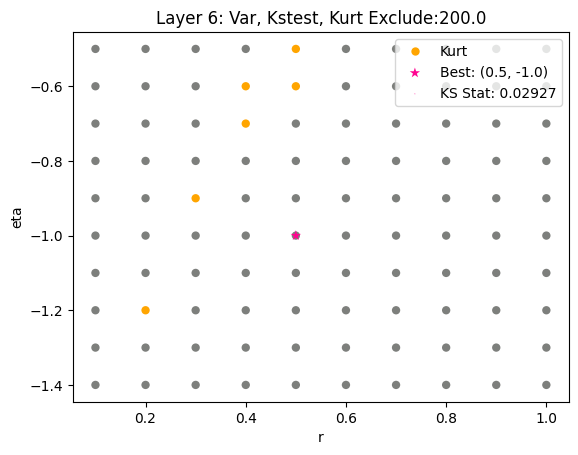

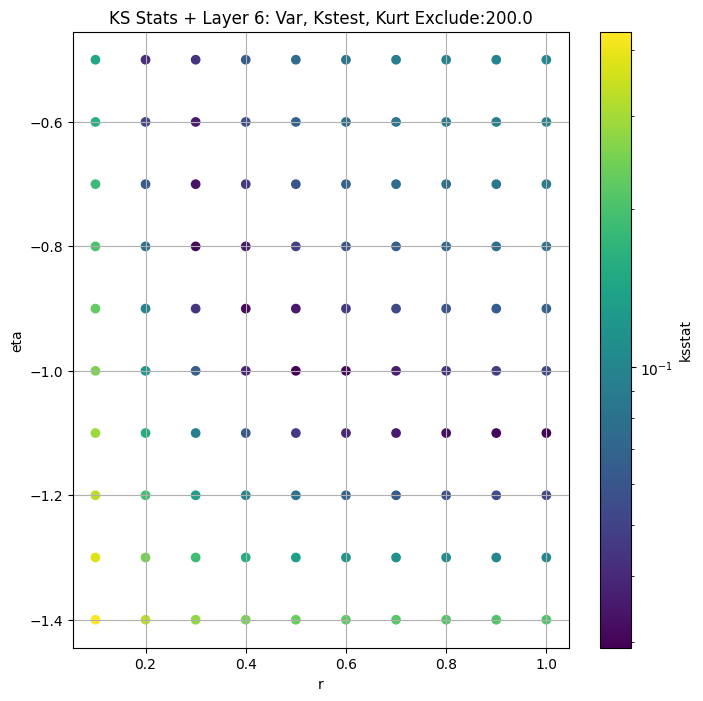

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.03004269099435261 1.917452


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.030215232594321018 1.8379792


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.030653669830708358 1.7887647


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.02933155923772912 1.7469691


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.02937163166509371 1.7097884


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.029575623154371566 1.644743


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.02919555069787172 1.5883737


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.028746393950447785 1.5380776


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.029146578943832768 1.4925519


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.028458144388961104 1.450821


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.028429469873807234 1.3419741
Number of samples: 100000, Without approximation : 1642496


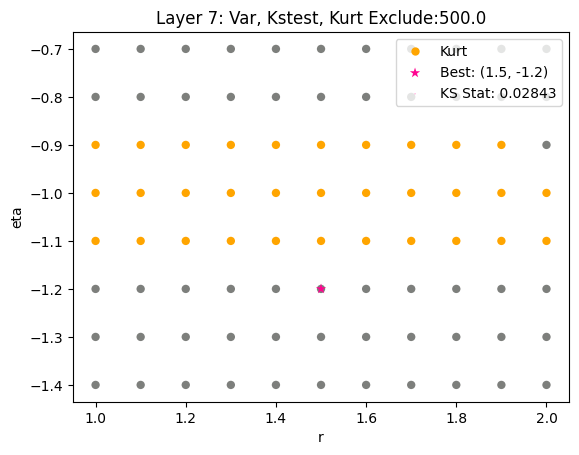

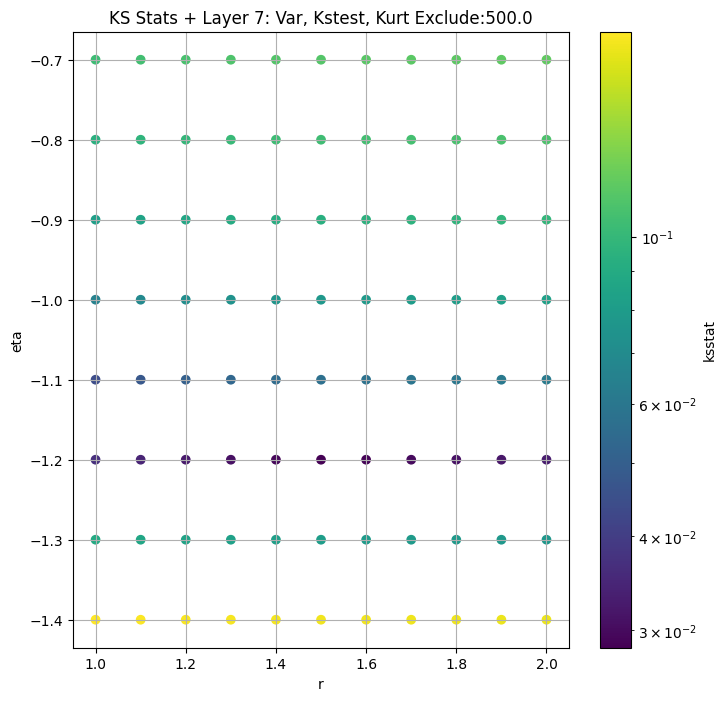

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.01668926636526974 0.35573384


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.015779616323267687 0.33504173


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.015236415219054333 0.32313457


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.014778786882762462 0.31321868


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.01615113966423154 0.30451286


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.01635839376929943 0.28951046


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.015666948935374403 0.27672505


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.015027769279903958 0.26549023


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.0144390668380881 0.25548294


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.013893736618065033 0.24643356


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.013274165276578154 0.22357844
Number of samples: 100000, Without approximation : 6569984


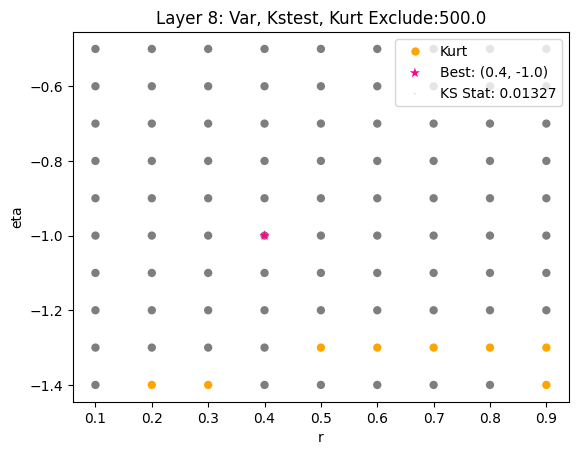

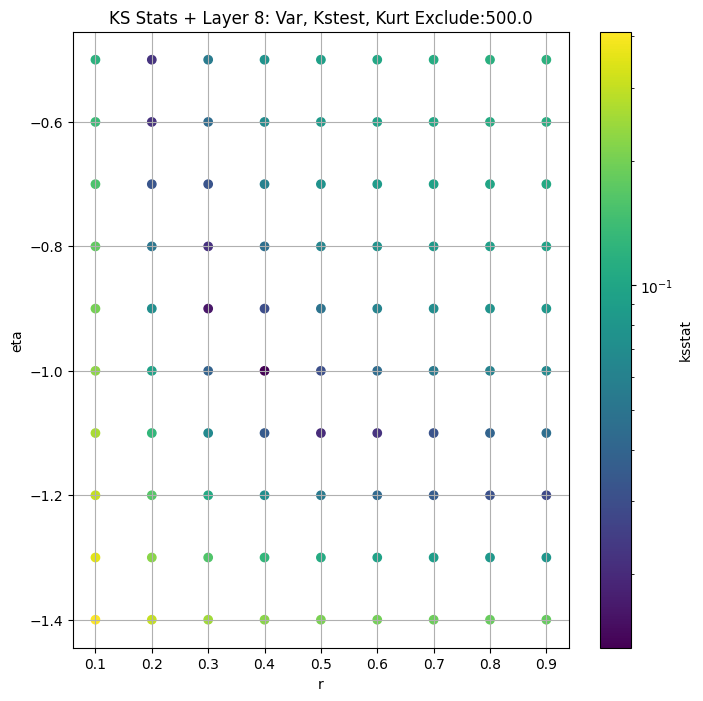

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.012115124737327232 0.07662222


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.01258164936696965 0.07050465


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.013073453578195893 0.067370154


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.012800434535873484 0.0648227


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.011273641151005931 0.06262443


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.00962491211604899 0.05891665


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.010173329682555576 0.05582656


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.012151648060492959 0.053161107


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.014260600293954262 0.05081597


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.014008186115774979 0.048722435


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.011902628696930151 0.043521583
Number of samples: 100000, Without approximation : 26279936


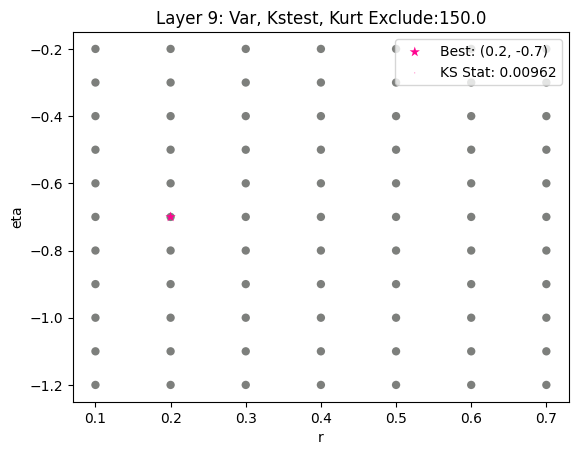

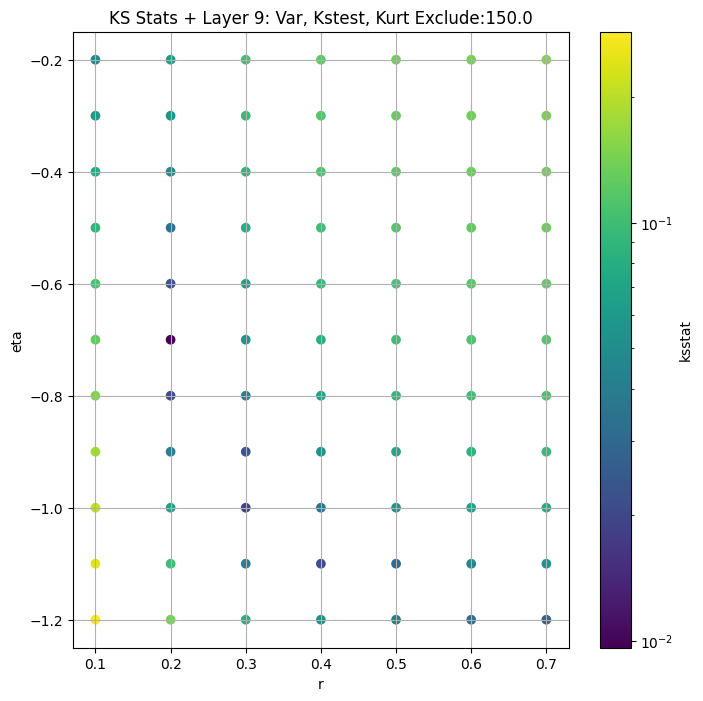

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      6559.191000  6020.007000  7105.842300  -0.362817   -0.544473   
3      1468.433300  1389.056300  1548.781900   0.855831    0.638626   
4       320.184020   302.725500   338.256230   2.609088    2.066685   
5        60.571945    56.585835    64.759430   4.962413    3.983900   
6        10.983582    10.096532    11.949500   8.753280    6.660281   
7         1.917452     1.728934     2.131029  14.216980   10.215151   
8         0.355734     0.312913     0.409800  24.594010   14.979433   
9         0.076622     0.065640     0.092390  41.164585   19.789228   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       -0.161276           1604             0.093047       20.0         20.0   
3        1.082630           6416             0.053912        7.7         -0.1   
4        3.449366          25664             0.042082        2.3         -0.9   
5        6.820006         102656             0.031317        1.6         -1.0   
6       15.588045         410624             0.029275        0.5         -1.0   
7       27.708519        1642496             0.028429        1.5         -1.2   
8       73.025085        6569984             0.013274        0.4         -1.0   
9      141.374480       26279936             0.009625        0.2         -0.7   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2        6699.713098                     0.0         6559.191000   
3        2122.498899                    75.0         1201.331200   
4         814.812175                    25.0          306.769040   
5         136.176780                   500.0           49.421990   
6           4.777120                   200.0            9.554240   
7           5.615759                   500.0            1.341974   
8           0.045818                   500.0            0.223578   
9           0.000009                   150.0            0.058917   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.033804  
3                     0.016929  
4                     0.008471  
5                     0.004237  
6                     0.002119  
7                     0.001060  
8                     0.000530  
9                     0.000265

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.13554398484013153, var: 4026.054931640625


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.12305369624564444, var: 4465.4814453125


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.1103002755471405, var: 4967.529296875


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.10008400978118537, var: 5602.90625


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.09304686353165215, var: 6559.19091796875
Number of samples: 1604, Without approximation : 1604


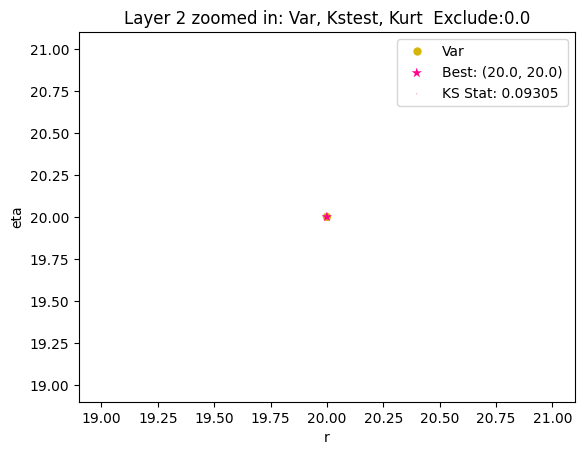

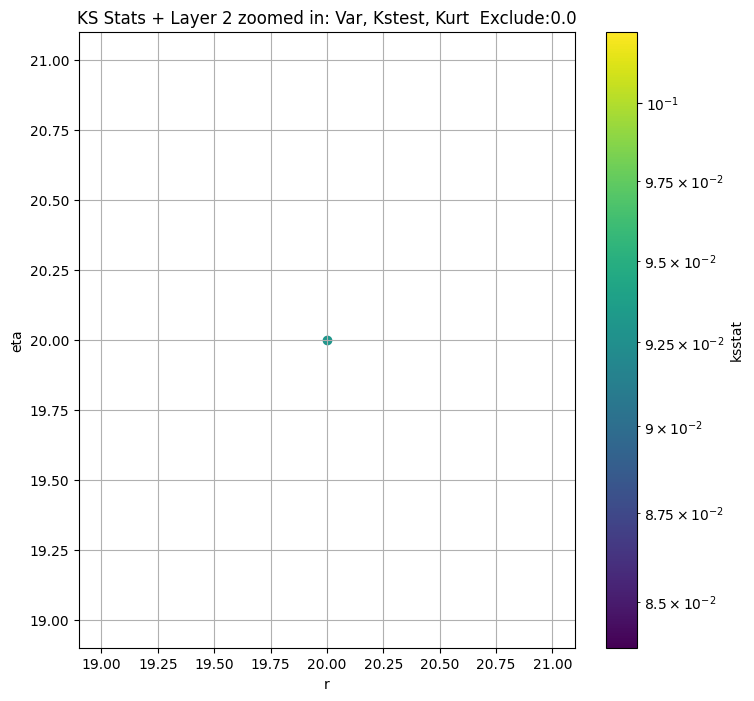

Layer 3


  0%|          | 0/144 [00:00<?, ?it/s]

Finding Minimum after computing 144 CDFs
layer 3, 75.0 + 100 = 175, ksstat: 0.055447739872153345, var: 998.468017578125


  0%|          | 0/144 [00:00<?, ?it/s]

Finding Minimum after computing 144 CDFs
layer 3, 75.0 + 75 = 150, ksstat: 0.05423662026777032, var: 1042.199462890625


  0%|          | 0/144 [00:00<?, ?it/s]

Finding Minimum after computing 144 CDFs
layer 3, 75.0 + 50 = 125, ksstat: 0.054001249764042414, var: 1089.6707763671875


  0%|          | 0/144 [00:00<?, ?it/s]

Finding Minimum after computing 144 CDFs
layer 3, 75.0 + 25 = 100, ksstat: 0.05402625975528996, var: 1141.6298828125


  0%|          | 0/144 [00:00<?, ?it/s]

Finding Minimum after computing 144 CDFs
layer 3, 75.0 + 0 = 75, ksstat: 0.053911583107604466, var: 1201.3311767578125


  0%|          | 0/144 [00:00<?, ?it/s]

Finding Minimum after computing 144 CDFs
layer 3, 75.0 + -25 = 50, ksstat: 0.05391198550428372, var: 1269.3677978515625


  0%|          | 0/144 [00:00<?, ?it/s]

Finding Minimum after computing 144 CDFs
layer 3, 75.0 + -50 = 25, ksstat: 0.0539195450083651, var: 1349.739990234375


  0%|          | 0/144 [00:00<?, ?it/s]

Finding Minimum after computing 144 CDFs
layer 3, 75.0 + -75 = 0, ksstat: 0.05392522599243188, var: 1468.433349609375
Number of samples: 6416, Without approximation : 6416


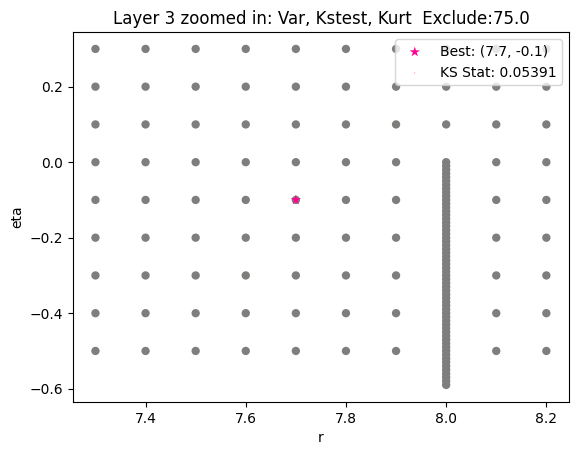

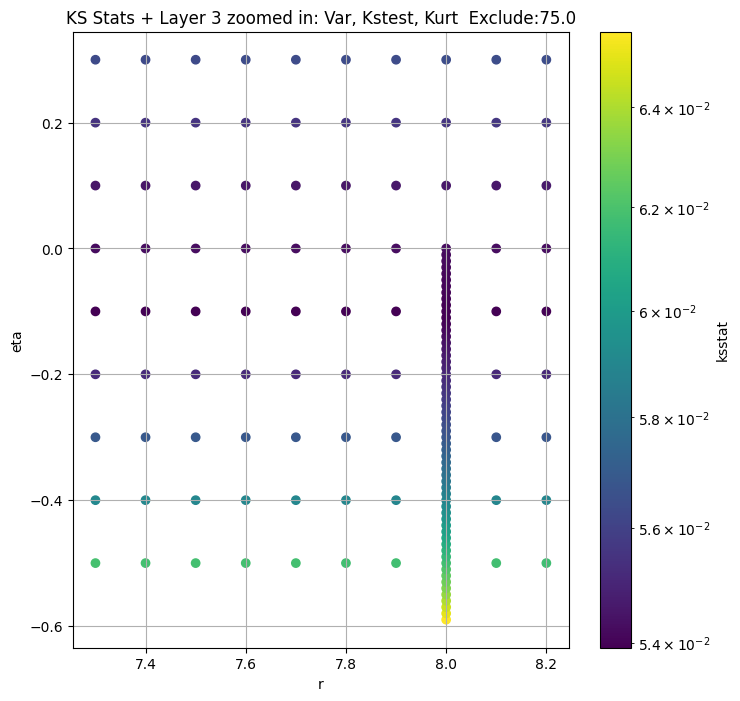

Layer 4


  0%|          | 0/550 [00:00<?, ?it/s]

Finding Minimum after computing 550 CDFs
layer 4, 25.0 + 100 = 125, ksstat: 0.04219486447181775, var: 276.70806884765625


  0%|          | 0/550 [00:00<?, ?it/s]

Finding Minimum after computing 550 CDFs
layer 4, 25.0 + 75 = 100, ksstat: 0.0421968226973678, var: 283.2557373046875


  0%|          | 0/550 [00:00<?, ?it/s]

Finding Minimum after computing 550 CDFs
layer 4, 25.0 + 50 = 75, ksstat: 0.04217205459822582, var: 290.2609558105469


  0%|          | 0/550 [00:00<?, ?it/s]

Finding Minimum after computing 550 CDFs
layer 4, 25.0 + 25 = 50, ksstat: 0.04208650866083358, var: 297.9342041015625


  0%|          | 0/550 [00:00<?, ?it/s]

Finding Minimum after computing 550 CDFs
layer 4, 25.0 + 0 = 25, ksstat: 0.04208156774107352, var: 306.76904296875


  0%|          | 0/550 [00:00<?, ?it/s]

Finding Minimum after computing 550 CDFs
layer 4, 25.0 + -25 = 0, ksstat: 0.04207882446998351, var: 320.18402099609375
Number of samples: 25664, Without approximation : 25664


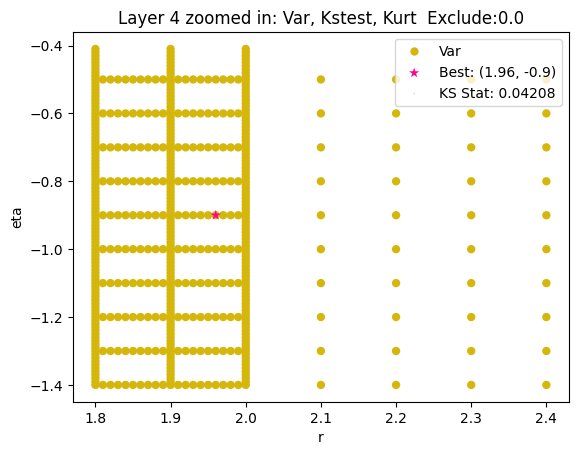

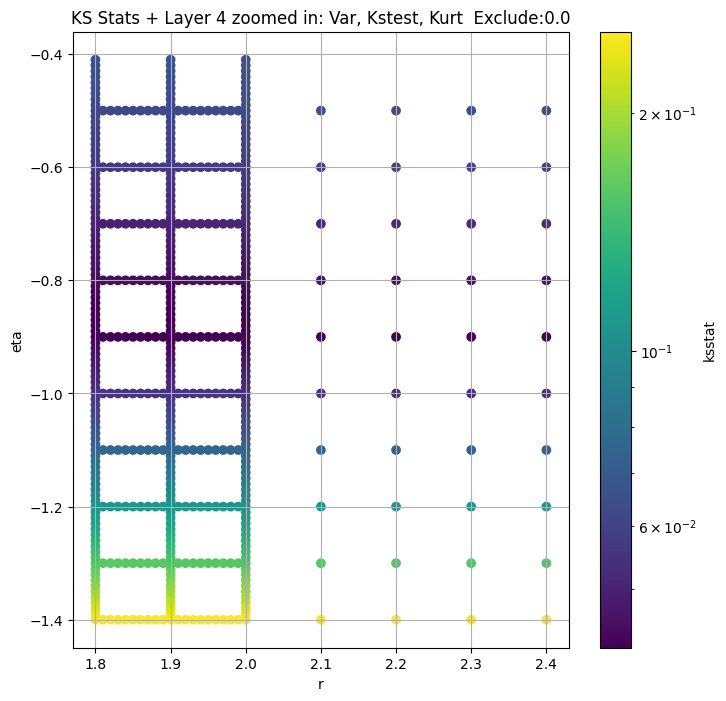

Layer 5


  0%|          | 0/1584 [00:00<?, ?it/s]

Finding Minimum after computing 1584 CDFs
layer 5, 500.0 + 100 = 600, ksstat: 0.03131754621659788, var: 48.01974868774414


  0%|          | 0/1584 [00:00<?, ?it/s]

Finding Minimum after computing 1584 CDFs
layer 5, 500.0 + 75 = 575, ksstat: 0.03131708092794194, var: 48.3595085144043


  0%|          | 0/1584 [00:00<?, ?it/s]

Finding Minimum after computing 1584 CDFs
layer 5, 500.0 + 50 = 550, ksstat: 0.031316404985883506, var: 48.706520080566406


  0%|          | 0/1584 [00:00<?, ?it/s]

Finding Minimum after computing 1584 CDFs
layer 5, 500.0 + 25 = 525, ksstat: 0.03131788519132056, var: 49.060970306396484


  0%|          | 0/1584 [00:00<?, ?it/s]

Finding Minimum after computing 1584 CDFs
layer 5, 500.0 + 0 = 500, ksstat: 0.03131682954479709, var: 49.42198944091797


  0%|          | 0/1584 [00:00<?, ?it/s]

Finding Minimum after computing 1584 CDFs
layer 5, 500.0 + -25 = 475, ksstat: 0.031315516252572784, var: 49.791019439697266


  0%|          | 0/1584 [00:00<?, ?it/s]

Finding Minimum after computing 1584 CDFs
layer 5, 500.0 + -50 = 450, ksstat: 0.03131662989613626, var: 50.16829299926758


  0%|          | 0/1584 [00:00<?, ?it/s]

Finding Minimum after computing 1584 CDFs
layer 5, 500.0 + -75 = 425, ksstat: 0.03131486396621902, var: 50.55364227294922


  0%|          | 0/1584 [00:00<?, ?it/s]

Finding Minimum after computing 1584 CDFs
layer 5, 500.0 + -100 = 400, ksstat: 0.03131861196327512, var: 50.94828796386719
Number of samples: 100000, Without approximation : 102656


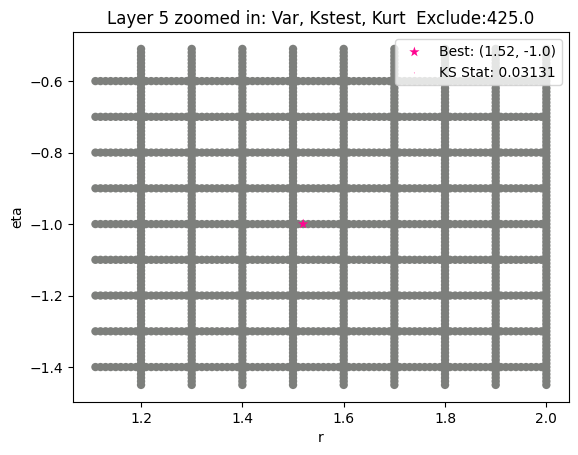

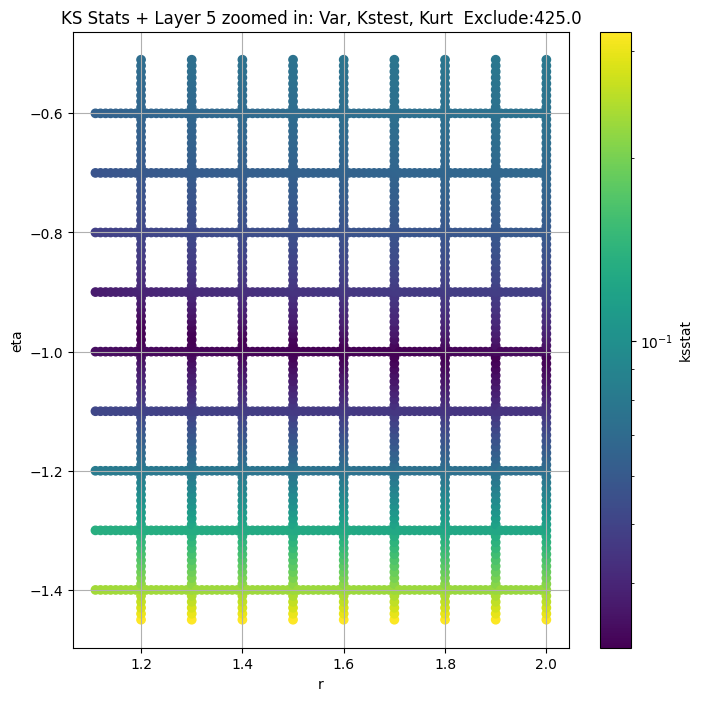

Layer 6


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 200.0 + 100 = 300, ksstat: 0.028530571960439233, var: 9.106451034545898


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 200.0 + 75 = 275, ksstat: 0.028635086097342943, var: 9.211609840393066


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 200.0 + 50 = 250, ksstat: 0.02868985097806742, var: 9.32088851928711


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 200.0 + 25 = 225, ksstat: 0.028747474172340137, var: 9.434730529785156


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 200.0 + 0 = 200, ksstat: 0.028720380685134717, var: 9.554240226745605


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 200.0 + -25 = 175, ksstat: 0.02868110708864241, var: 9.679760932922363


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 200.0 + -50 = 150, ksstat: 0.028742454103811876, var: 9.81181526184082


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 200.0 + -75 = 125, ksstat: 0.028653763508203367, var: 9.952073097229004


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 200.0 + -100 = 100, ksstat: 0.028450973211418762, var: 10.102999687194824
Number of samples: 100000, Without approximation : 410624


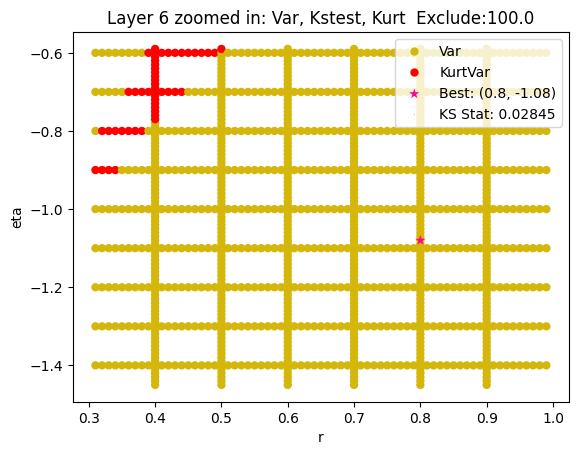

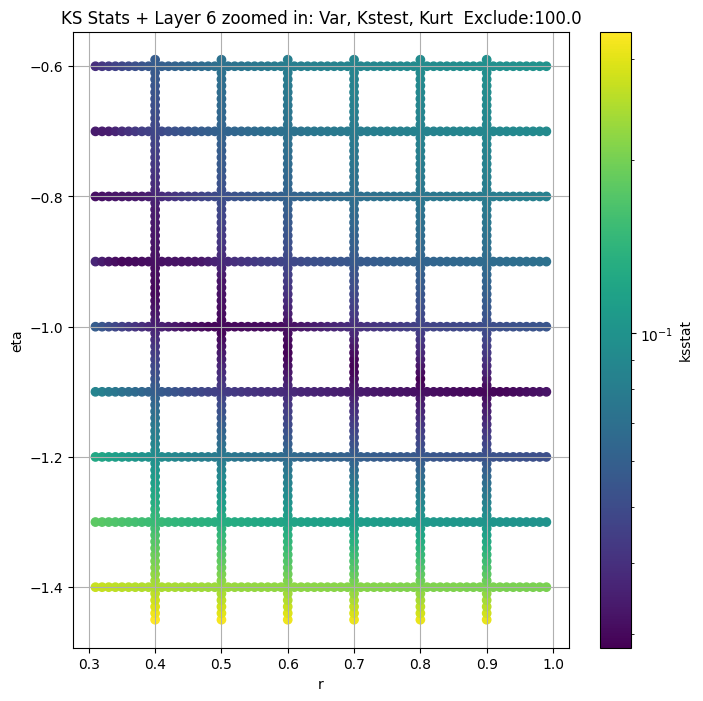

Layer 7


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 500.0 + 100 = 600, ksstat: 0.027088281823445526, var: 1.2796846628189087


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 500.0 + 75 = 575, ksstat: 0.02680103247779747, var: 1.2946046590805054


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 500.0 + 50 = 550, ksstat: 0.027348244854108472, var: 1.309949278831482


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 500.0 + 25 = 525, ksstat: 0.02722265415223246, var: 1.3257358074188232


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 500.0 + 0 = 500, ksstat: 0.02686594925840846, var: 1.341974139213562


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 500.0 + -25 = 475, ksstat: 0.02700375775210767, var: 1.3586974143981934


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 500.0 + -50 = 450, ksstat: 0.027143615344942973, var: 1.3759440183639526


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 500.0 + -75 = 425, ksstat: 0.027286658555146837, var: 1.3937342166900635


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 500.0 + -100 = 400, ksstat: 0.027215956906248867, var: 1.4121049642562866
Number of samples: 100000, Without approximation : 1642496


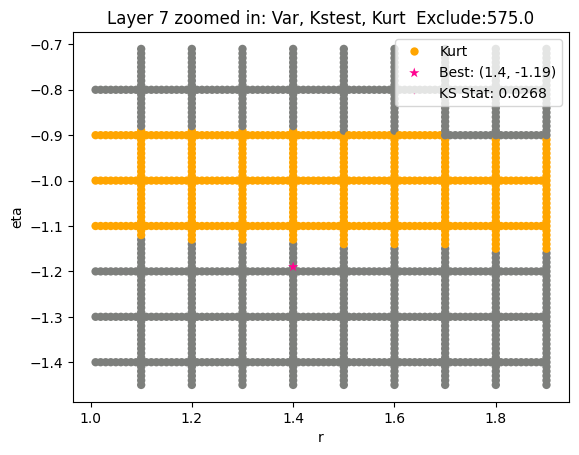

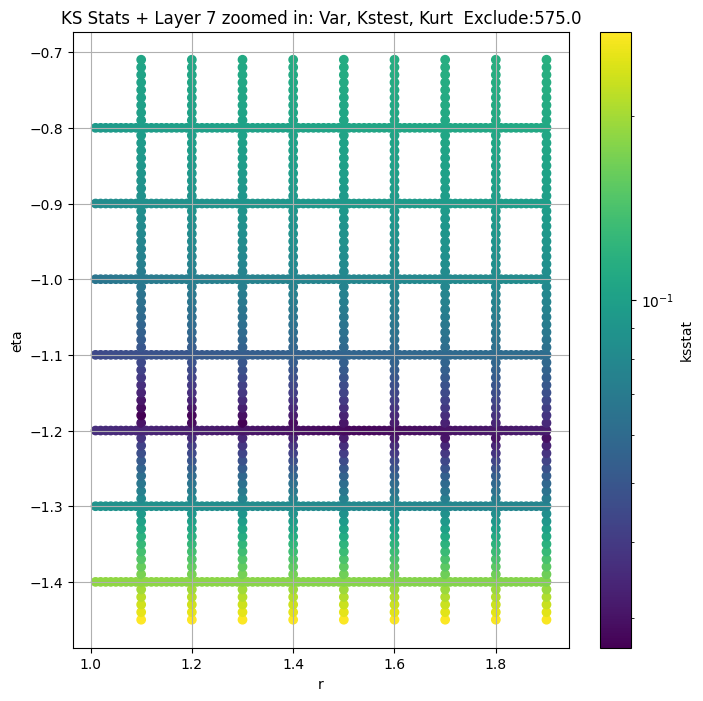

Layer 8


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 8, 500.0 + 100 = 600, ksstat: 0.013241871708790265, var: 0.21092522144317627


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 8, 500.0 + 75 = 575, ksstat: 0.013185569912900486, var: 0.21393491327762604


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 8, 500.0 + 50 = 550, ksstat: 0.013346599571213313, var: 0.21704250574111938


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 8, 500.0 + 25 = 525, ksstat: 0.013334170607645801, var: 0.22025372087955475


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 8, 500.0 + 0 = 500, ksstat: 0.013274165276578154, var: 0.22357843816280365


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 8, 500.0 + -25 = 475, ksstat: 0.013213251407030169, var: 0.227024644613266


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 8, 500.0 + -50 = 450, ksstat: 0.013360909060252557, var: 0.2305998057126999


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 8, 500.0 + -75 = 425, ksstat: 0.013363411835827121, var: 0.23431670665740967


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 8, 500.0 + -100 = 400, ksstat: 0.013296332860564253, var: 0.23818422853946686
Number of samples: 100000, Without approximation : 6569984


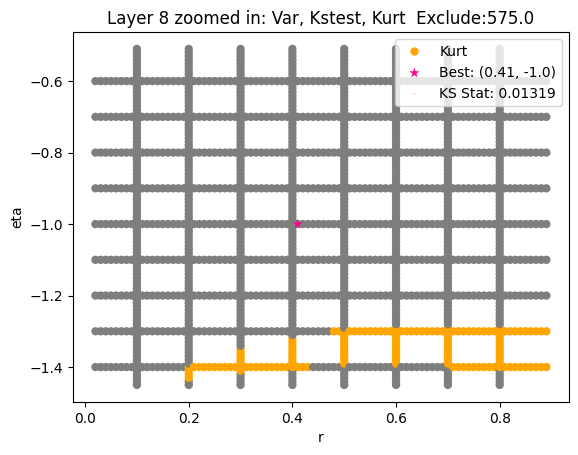

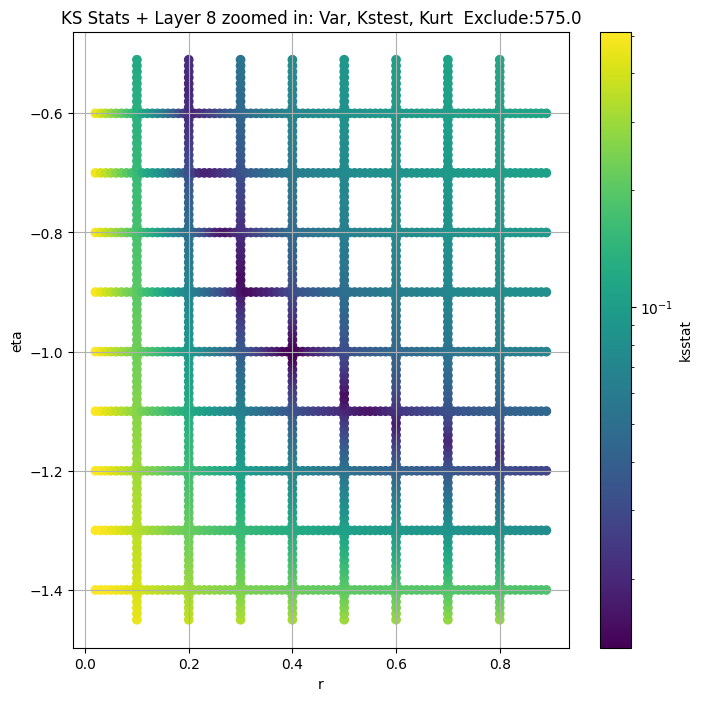

Layer 9


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 150.0 + 100 = 250, ksstat: 0.010244842484095351, var: 0.05316110700368881


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 150.0 + 75 = 225, ksstat: 0.010265011194845797, var: 0.05444858968257904


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 150.0 + 50 = 200, ksstat: 0.009691087553274191, var: 0.05582655966281891


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 150.0 + 25 = 175, ksstat: 0.009608317748594275, var: 0.057309556752443314


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 150.0 + 0 = 150, ksstat: 0.00962491211604899, var: 0.05891665071249008


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 150.0 + -25 = 125, ksstat: 0.009871952085683366, var: 0.060674939304590225


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 150.0 + -50 = 100, ksstat: 0.009901220245648712, var: 0.06262443214654922


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 150.0 + -75 = 75, ksstat: 0.009792275879149659, var: 0.06482270359992981


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 150.0 + -100 = 50, ksstat: 0.00945088200688382, var: 0.06737015396356583
Number of samples: 100000, Without approximation : 26279936


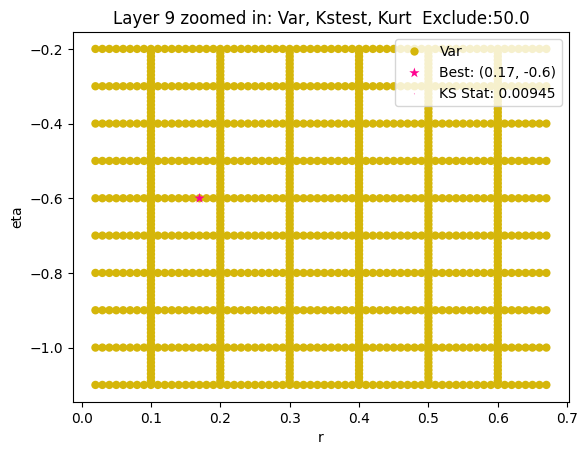

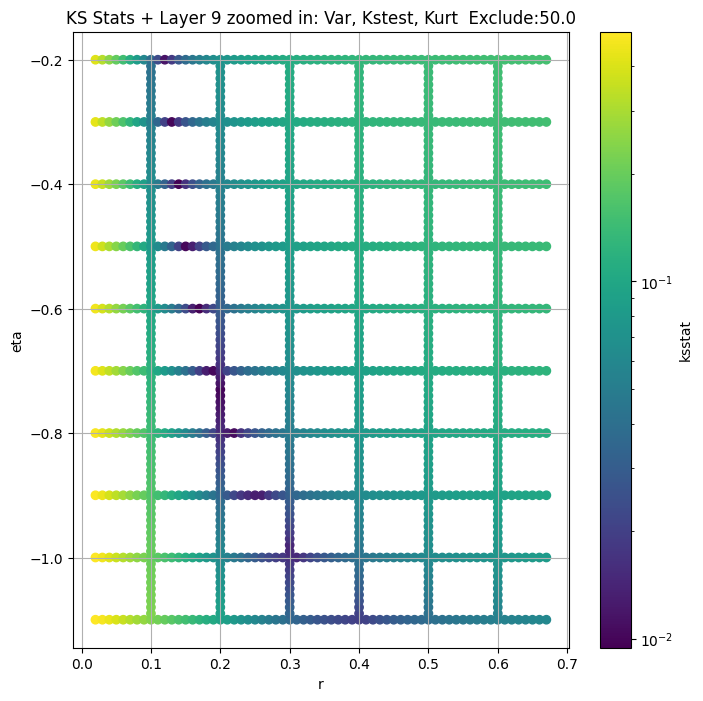

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      6559.191000  6020.007000  7105.842300  -0.362817   -0.544473   
3      1468.433300  1389.056300  1548.781900   0.855831    0.638626   
4       320.184020   302.725500   338.256230   2.609088    2.066685   
5        60.571945    56.585835    64.759430   4.962413    3.983900   
6        10.983582    10.096532    11.949500   8.753280    6.660281   
7         1.917452     1.728934     2.131029  14.216980   10.215151   
8         0.355734     0.312913     0.409800  24.594010   14.979433   
9         0.076622     0.065640     0.092390  41.164585   19.789228   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       -0.161276           1604             0.093047       20.0         20.0   
3        1.082630           6416             0.053912        7.7         -0.1   
4        3.449366          25664             0.042082        2.3         -0.9   
5        6.820006         102656             0.031317        1.6         -1.0   
6       15.588045         410624             0.029275        0.5         -1.0   
7       27.708519        1642496             0.028429        1.5         -1.2   
8       73.025085        6569984             0.013274        0.4         -1.0   
9      141.374480       26279936             0.009625        0.2         -0.7   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2        6699.713098                     0.0         6559.191000   
3        2122.498899                    75.0         1201.331200   
4         814.812175                    25.0          320.184021   
5         136.176780                   500.0           50.553642   
6           4.777120                   200.0           10.103000   
7           5.615759                   500.0            1.294605   
8           0.045818                   500.0            0.213935   
9           0.000009                   150.0            0.067370   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.033804          0.093047   20.00     20.00   
3                     0.016929          0.053912    7.70     -0.10   
4                     0.008471          0.042079    1.96     -0.90   
5                     0.004237          0.031315    1.52     -1.00   
6                     0.002119          0.028451    0.80     -1.08   
7                     0.001060          0.026801    1.40     -1.19   
8                     0.000530          0.013186    0.41     -1.00   
9                     0.000265          0.009451    0.17     -0.60   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      6.699713e+03                  0.0          200  
3      2.122499e+03                 75.0          601  
4      8.180053e+02                  0.0         1012  
5      1.362583e+02                425.0         1804  
6      1.845963e+01                100.0         2281  
7      5.124148e+00                575.0         2706  
8      4.915367e-02                575.0        10827  
9      4.618376e-07                 50.0        21654

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

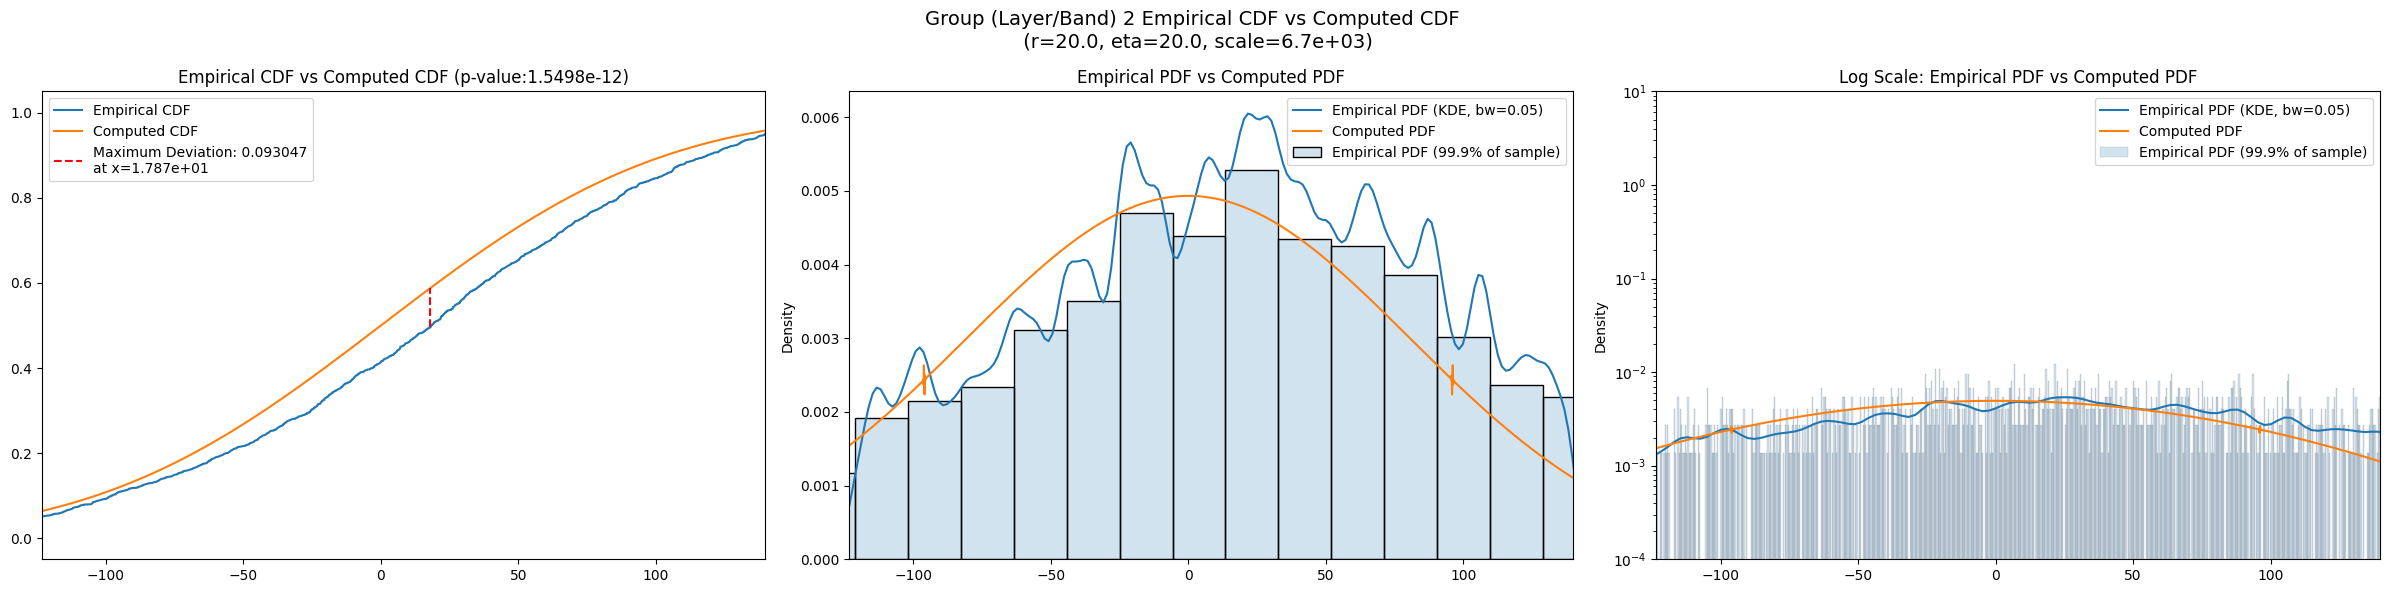

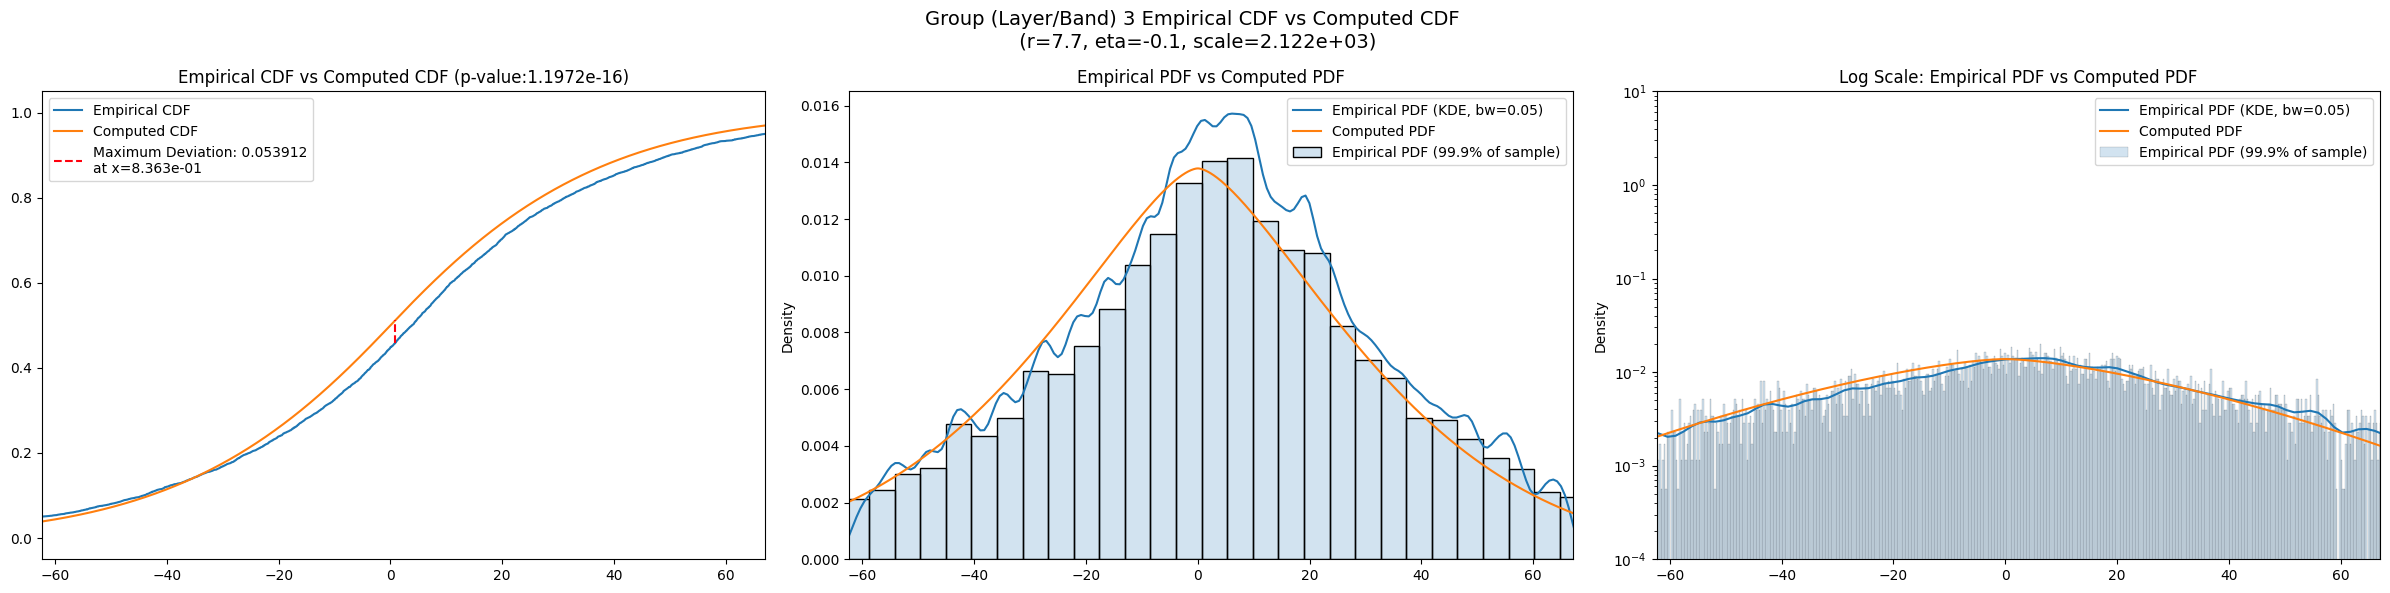

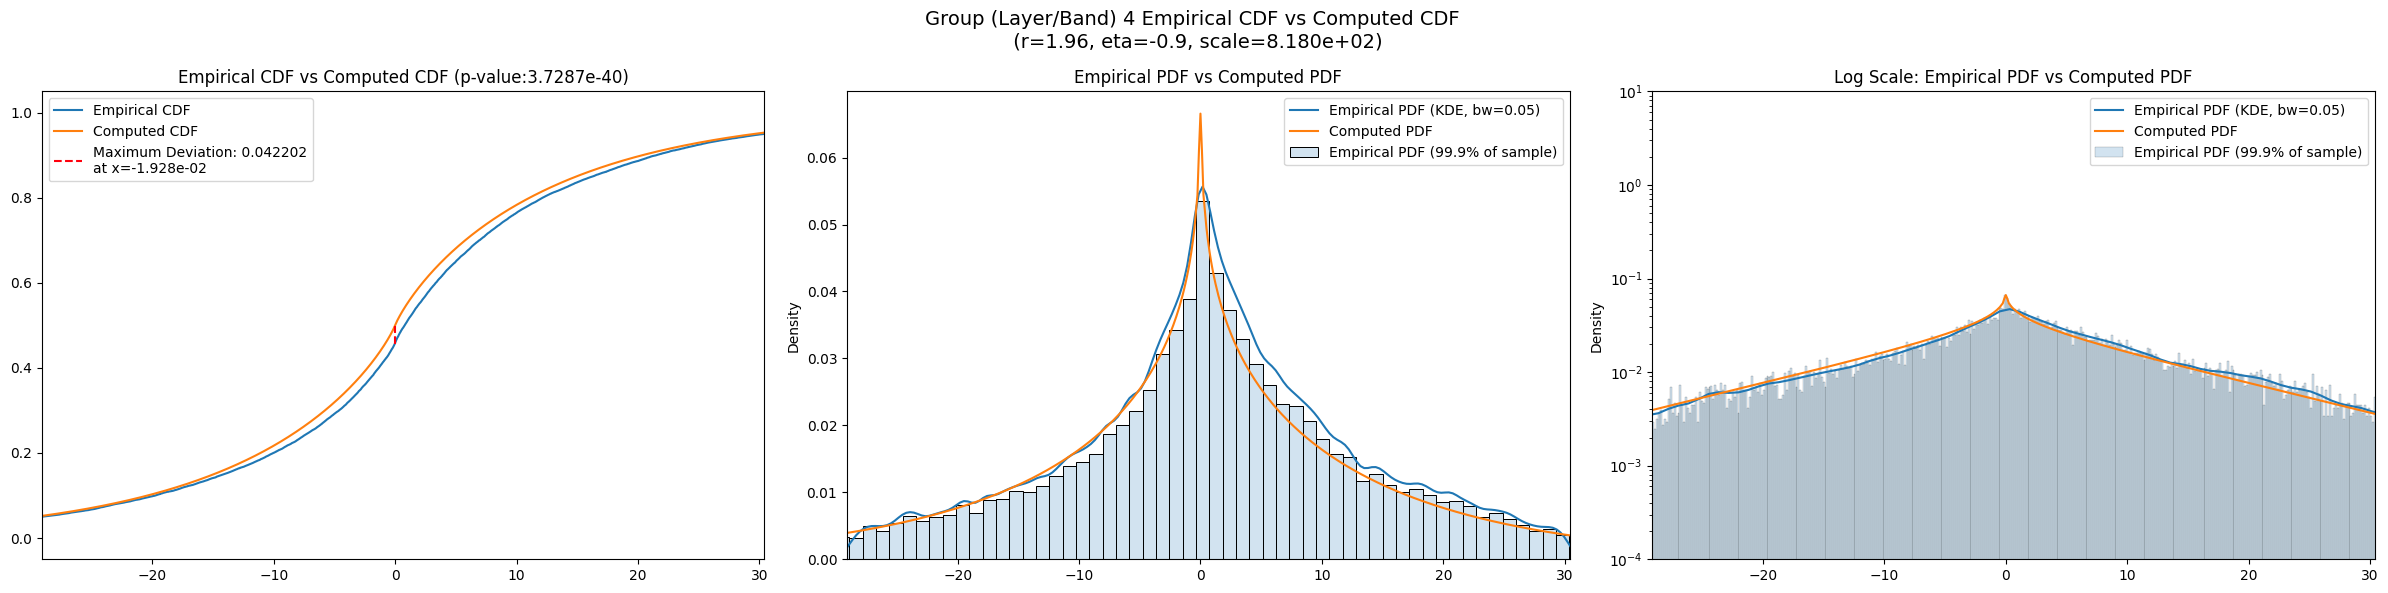

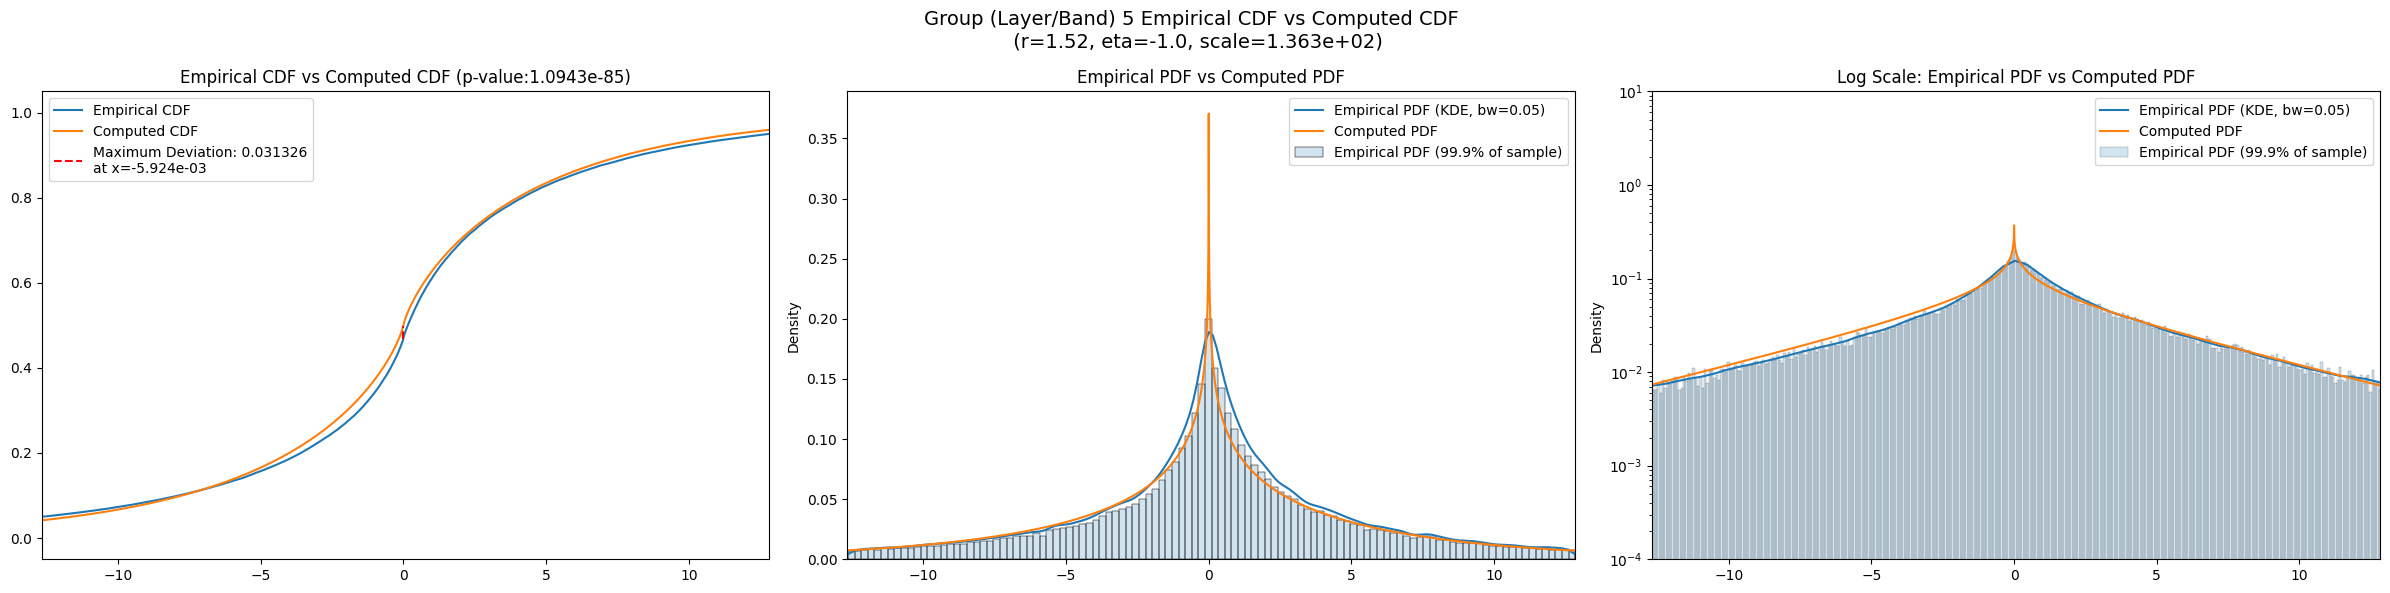

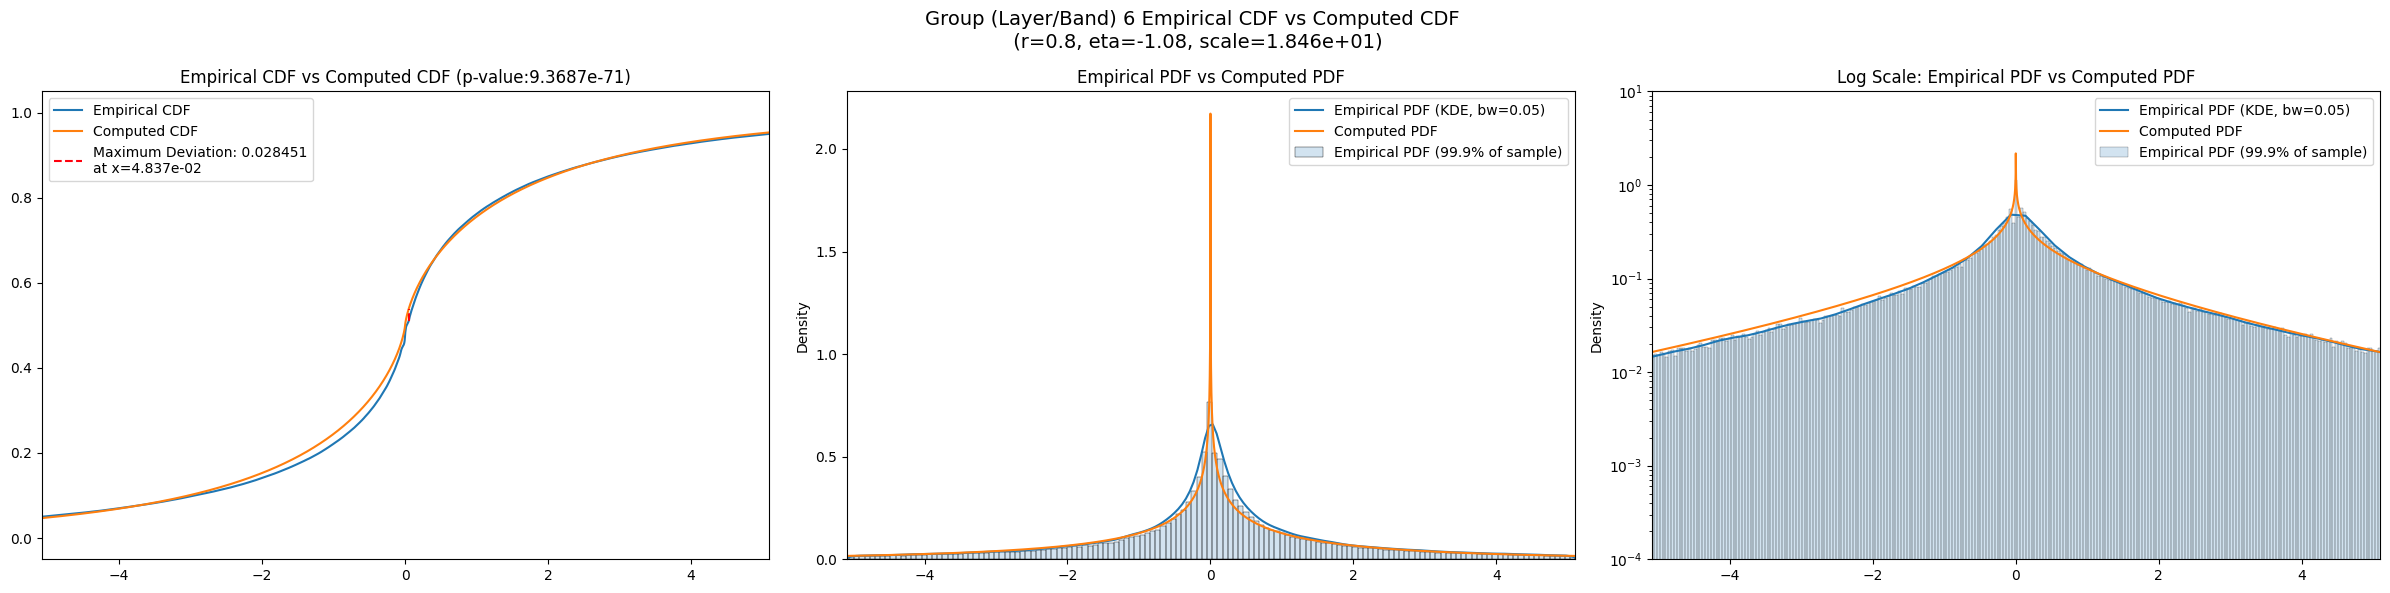

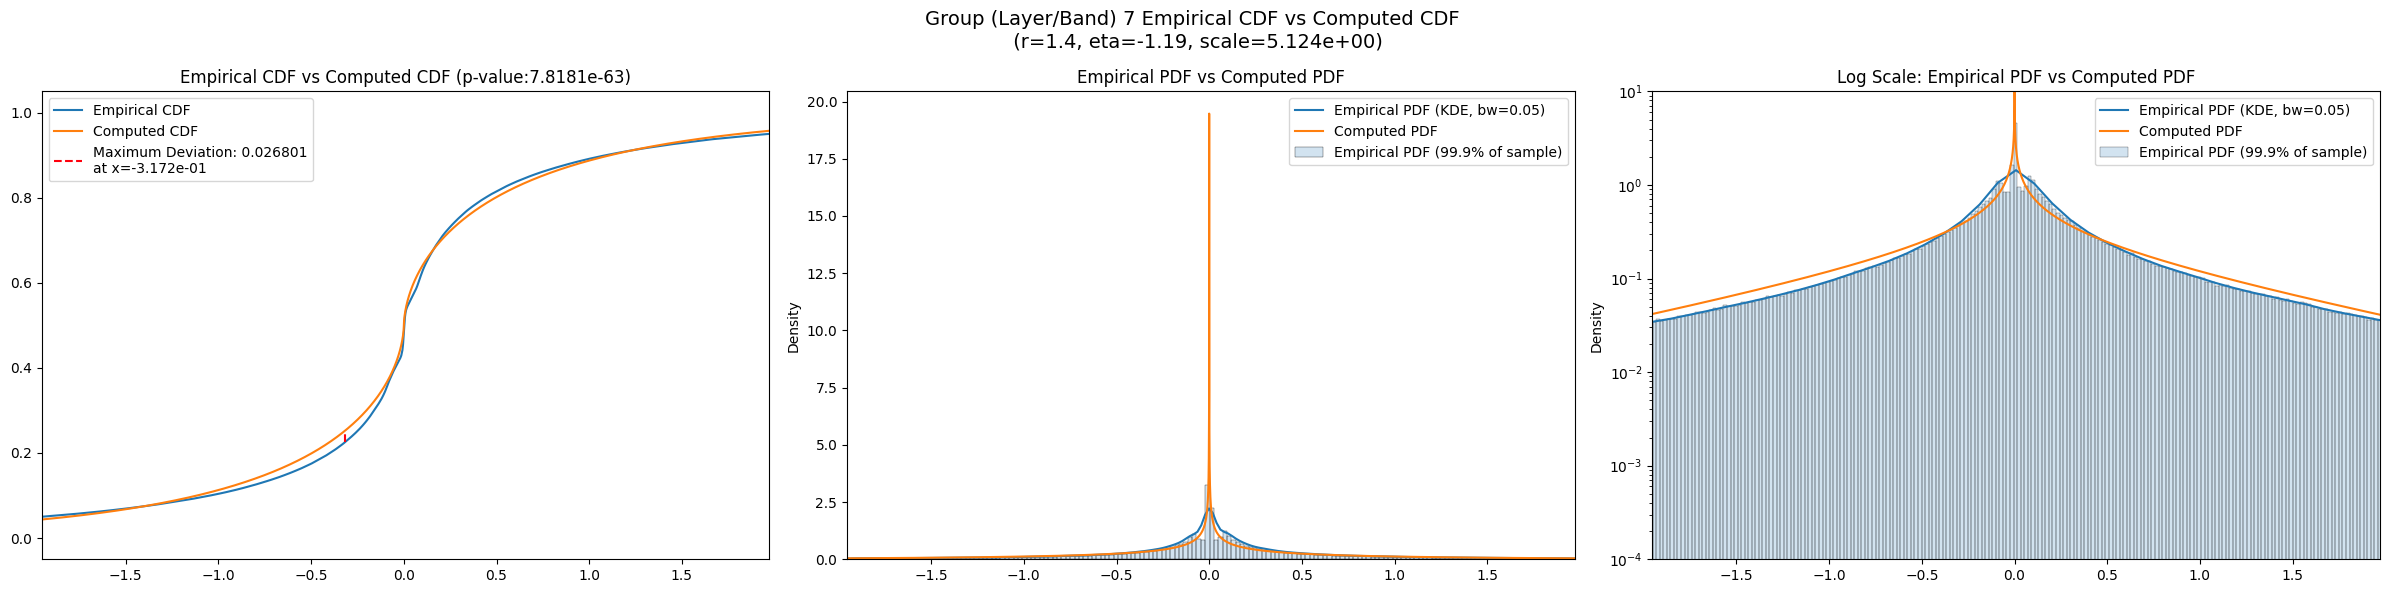

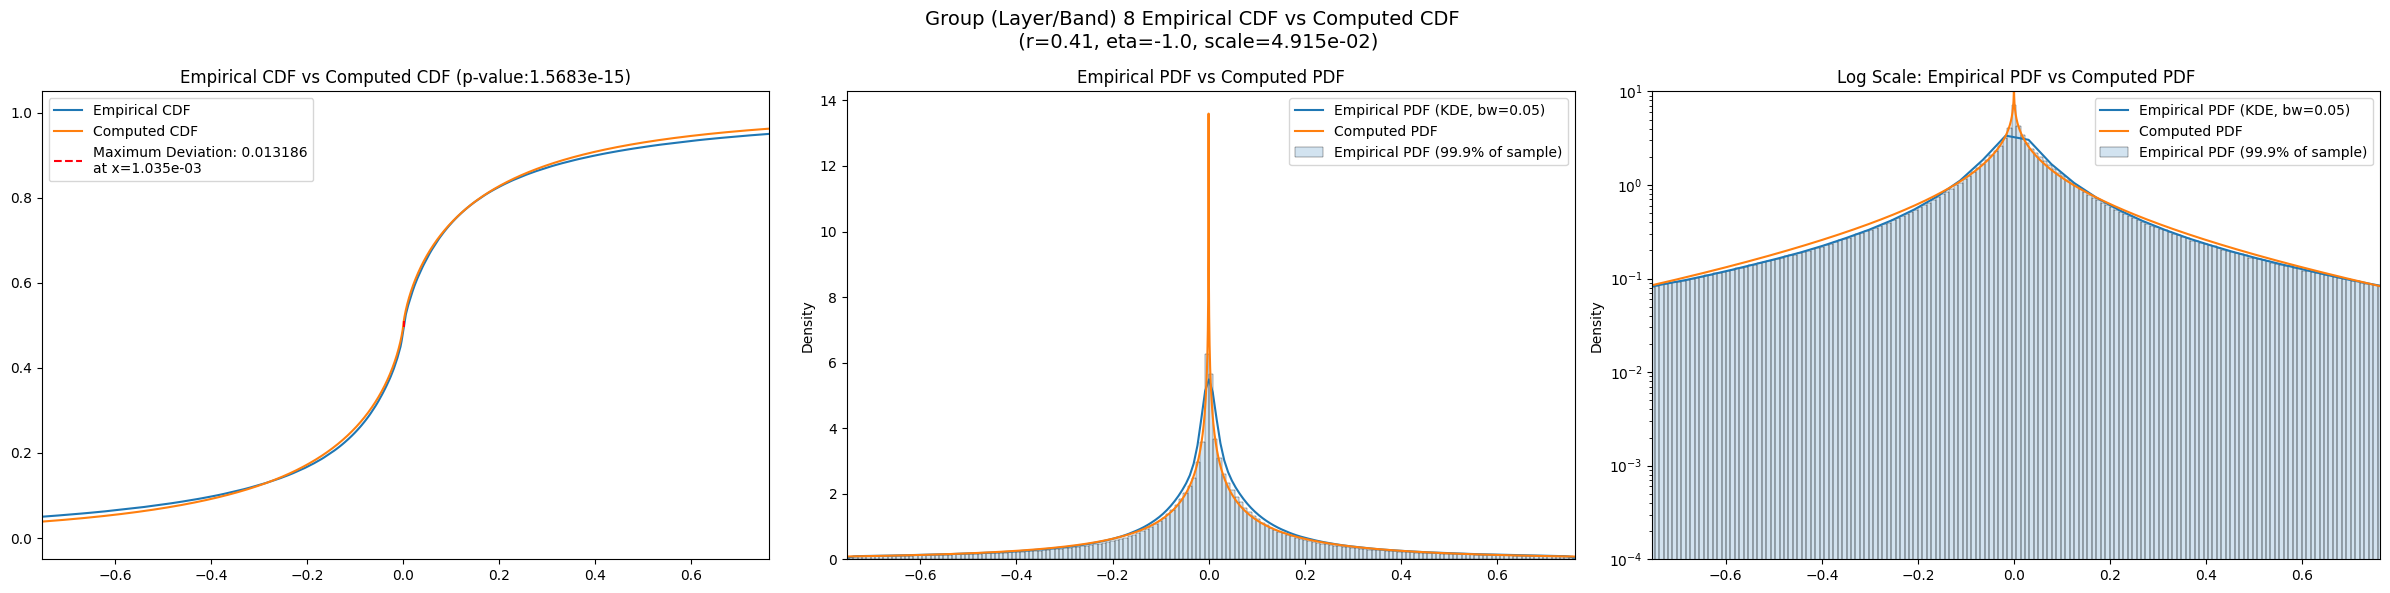

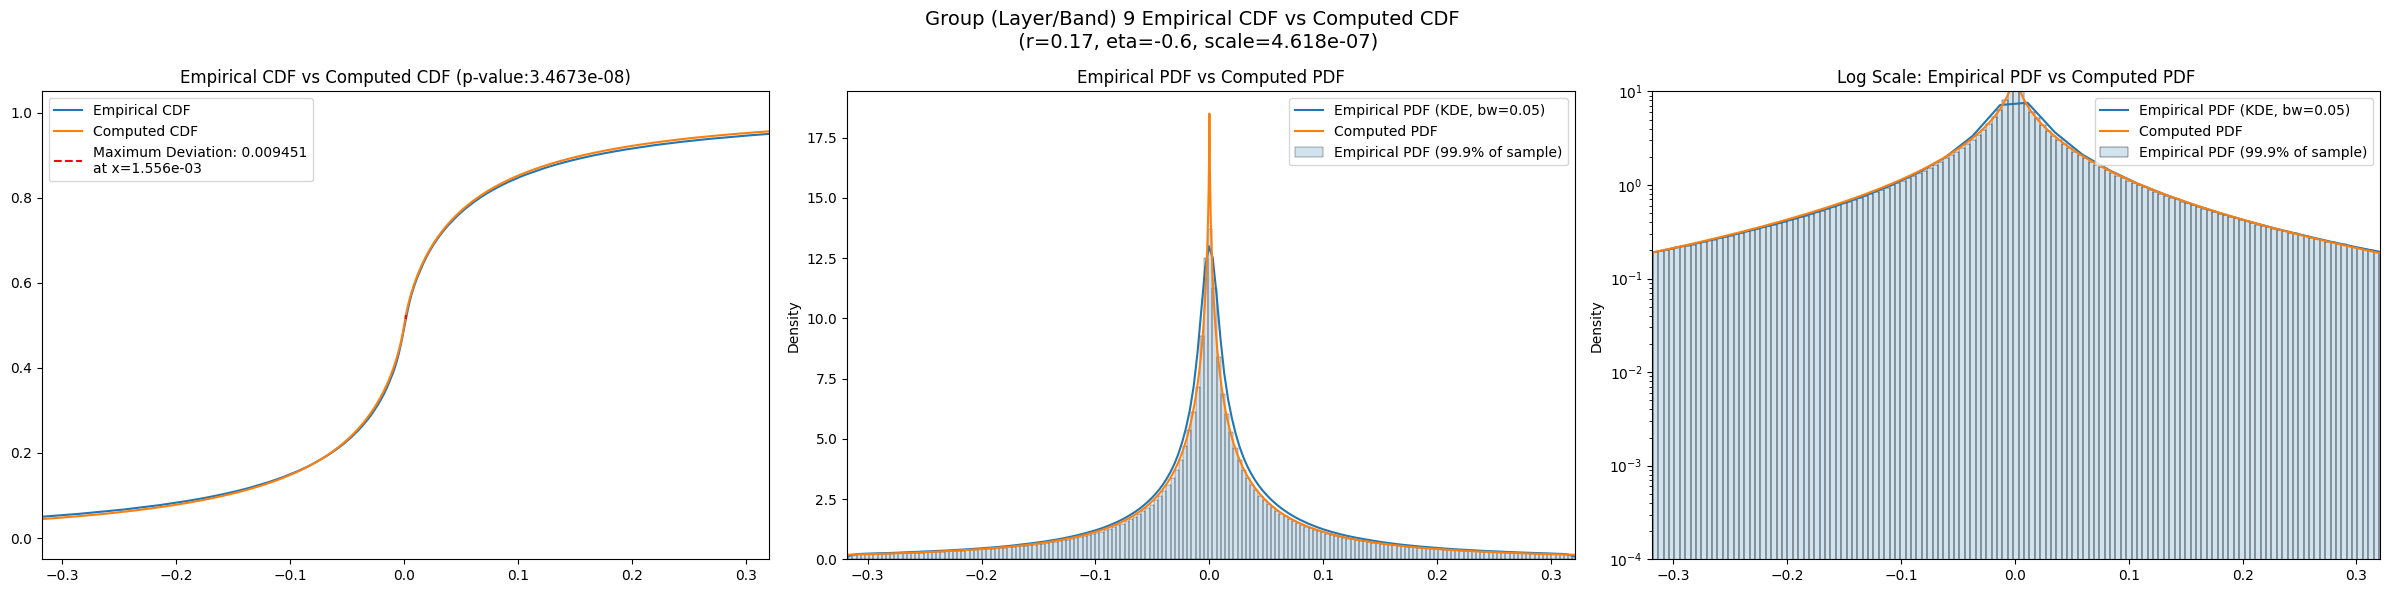

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      6559.191000  6020.007000  7105.842300  -0.362817   -0.544473   
3      1468.433300  1389.056300  1548.781900   0.855831    0.638626   
4       320.184020   302.725500   338.256230   2.609088    2.066685   
5        60.571945    56.585835    64.759430   4.962413    3.983900   
6        10.983582    10.096532    11.949500   8.753280    6.660281   
7         1.917452     1.728934     2.131029  14.216980   10.215151   
8         0.355734     0.312913     0.409800  24.594010   14.979433   
9         0.076622     0.065640     0.092390  41.164585   19.789228   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       -0.161276           1604             0.093047       20.0         20.0   
3        1.082630           6416             0.053912        7.7         -0.1   
4        3.449366          25664             0.042082        2.3         -0.9   
5        6.820006         102656             0.031317        1.6         -1.0   
6       15.588045         410624             0.029275        0.5         -1.0   
7       27.708519        1642496             0.028429        1.5         -1.2   
8       73.025085        6569984             0.013274        0.4         -1.0   
9      141.374480       26279936             0.009625        0.2         -0.7   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       89.106100              0.090046          9.107060e-12   
3      ...       30.496000              0.054833          3.301730e-17   
4      ...       12.433200              0.060493          4.402850e-82   
5      ...        4.454160              0.068738          0.000000e+00   
6      ...        1.520630              0.078511          0.000000e+00   
7      ...        0.524333              0.081771          0.000000e+00   
8      ...        0.202664              0.077521          0.000000e+00   
9      ...        0.083472              0.078479          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          97.468800             0.092475         2.182010e-12  78.101200   
3          35.136700             0.054154         8.551790e-17  25.735100   
4          10.549500             0.044553         1.050210e-44   8.918480   
5           3.798070             0.044956        1.007920e-180   3.088460   
6           1.293510             0.053611         0.000000e+00   1.026230   
7           0.451790             0.056398         0.000000e+00   0.350949   
8           0.176027             0.052246         0.000000e+00   0.135020   
9           0.072587             0.053055         0.000000e+00   0.055985   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.090262   8.032290e-12          1.549902e-12  
3           0.053945   1.143520e-16          1.197246e-16  
4           0.048621   3.656370e-53          6.364335e-40  
5           0.049937  6.475460e-223          6.842091e-88  
6           0.056626   0.000000e+00         3.442972e-289  
7           0.057765   0.000000e+00          0.000000e+00  
8           0.052791   0.000000e+00          0.000000e+00  
9           0.053130   0.000000e+00          0.000000e+00  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.093047                 0.033804          0.093047   
3                 0.053912                 0.016929          0.053912   
4                 0.042082                 0.008471          0.042079   
5                 0.031317                 0.004237          0.031315   
6                 0.029275                 0.002119          0.028451   
7                 0.028429                 0.001060          0.026801   
8                 0.013274                 0.000530          0.013186   
9                 0.009625                 0.000265          0.009451   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.090046             0.092475       0.090262  
3                  0.054833             0.054154       0.053945  
4                  0.060493             0.044553       0.048621  
5                  0.068738             0.044956       0.049937  
6                  0.078511             0.053611       0.056626  
7                  0.081771             0.056398       0.057765  
8                  0.077521             0.052246       0.052791  
9                  0.078479             0.053055       0.053130

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2             6559.191000          0.093047   20.00     20.00  6.699713e+03   
3             1201.331200          0.053912    7.70     -0.10  2.122499e+03   
4              320.184021          0.042079    1.96     -0.90  8.180053e+02   
5               50.553642          0.031315    1.52     -1.00  1.362583e+02   
6               10.103000          0.028451    0.80     -1.08  1.845963e+01   
7                1.294605          0.026801    1.40     -1.19  5.124148e+00   
8                0.213935          0.013186    0.41     -1.00  4.915367e-02   
9                0.067370          0.009451    0.17     -0.60  4.618376e-07   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                     75.0  
4                      0.0  
5                    425.0  
6                    100.0  
7                    575.0  
8                    575.0  
9                     50.0

In [21]:
eng.quit()